**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

# TO DELETE
mounting the drive

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Telecom/IMA205/TP3')
current_directory = os.getcwd()
print(current_directory)

Mounted at /content/drive
/content/drive/MyDrive/Telecom/IMA205/TP3


First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

# Preparations

## Setting path

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./"

In [ ]:
Working_directory="./"

Otherwise, you can also load them from your local machine using the following code

In [ ]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

## Loading python libraries

Let's load the Python packages containing the functions needed for the practical session.

In [ ]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline

## Defining utility functions

We also load a user-defined function useful for plotting the confusion matrix

In [ ]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Importing and exploring data

## Importing

Now, let's load the data.

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [ ]:
# Parameters
dim=2 # dimension
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']
N,M = X.shape # number subjects
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M)
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


## Exploring

### Visualization

Here, we show an example of facial landmarks

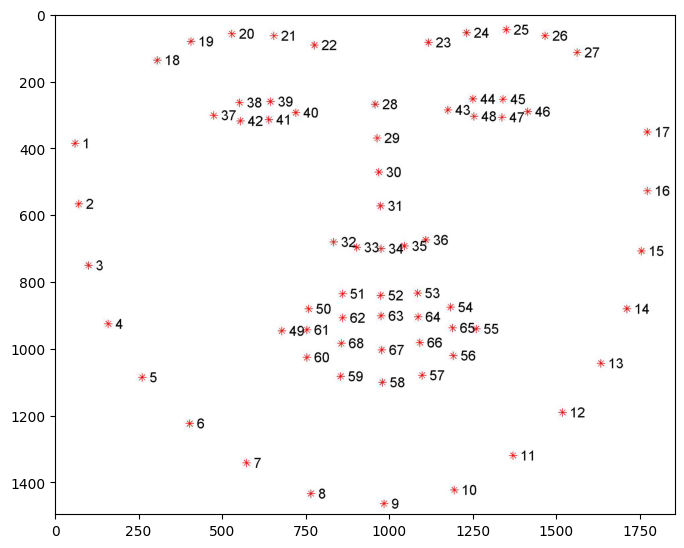

In [ ]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

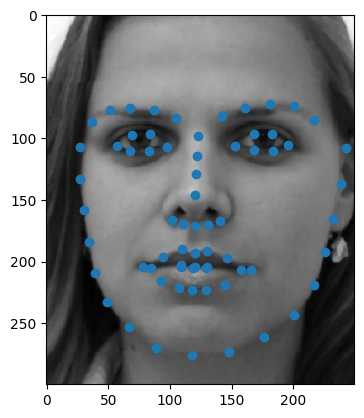

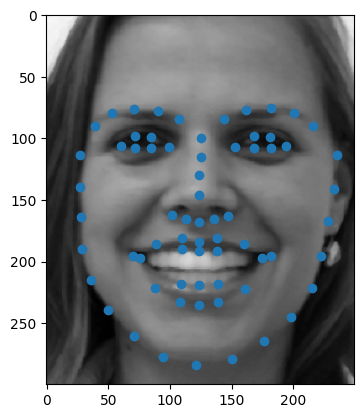

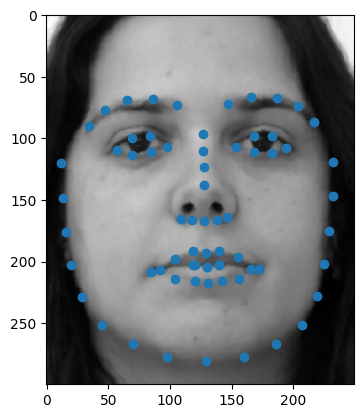

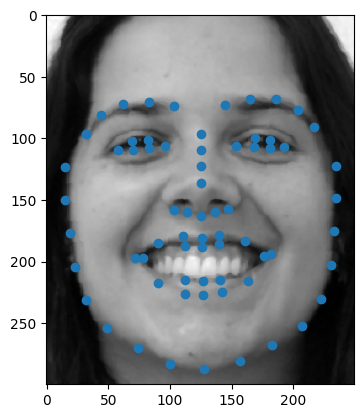

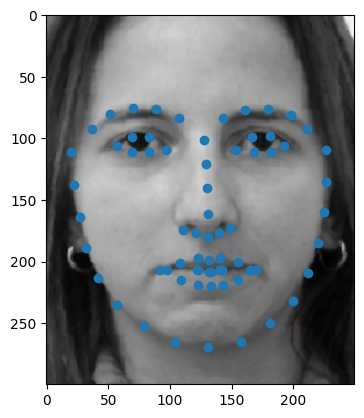

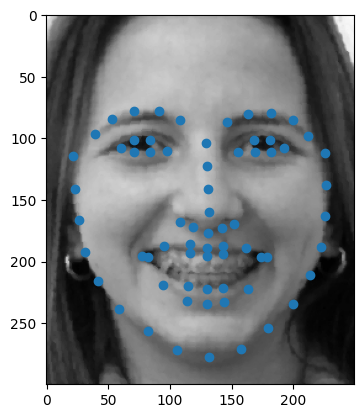

In [ ]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

## Shuffiling



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---



**Answer**

Yes. By observing the first 6 samples we can noitce a pattern in the data. First, all the images come from female subjects. Second, the images comes in pairs of the same subject being in neutral state then in happy state.  I think it would be worth it to randomly shuffle the data to avoid any bais that can occur.

In [ ]:
np.random.seed(66)
# Shuffle data randomly. Hint: Use np.random.shuffle
indeces =[i for i in range(N)]
np.random.shuffle(indeces)

XpGPA=XGPA[indeces]
Xp=X[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]
Xmean = np.mean(XpGPA,axis=0) # Compute average

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]

### GPA



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


**QUESTION**: Please comment the results. What can you notice ?




---



**Answer**

After using GPA, we noitice that the variance of the positioning of the landmarks is reduced. This can help us to be able to better identify the subject state given that the important points are more precisly given (such as those of the mouth and the eyes)

Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

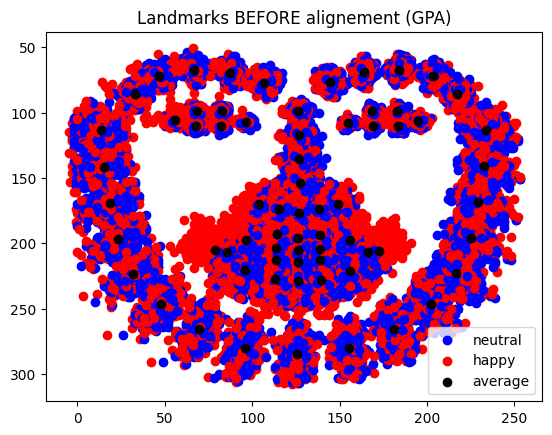

In [ ]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

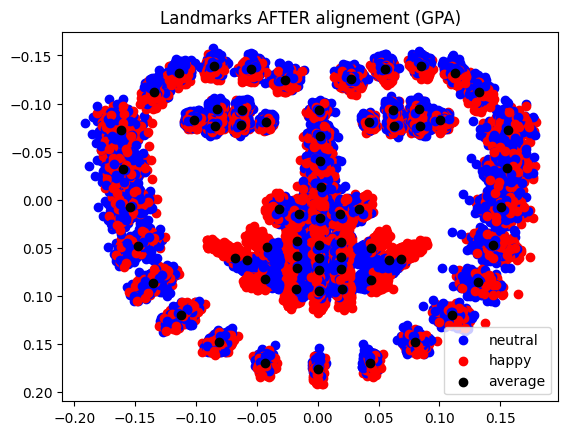

In [ ]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the landmarks of every subject and the landmarks of the average configuration.



---



# Preprocessing

## Extracting new features : distance from average

In [ ]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
average=np.reshape(Xmean,(M,2)) # Reshape average as matrix

for i in range(XpGPA.shape[0]):
  landmark=XpGPA[i]
  x=landmark[::2]
  y=landmark[1::2]
  xm,ym=Xmean[::2],Xmean[1::2]
  dist_average[i,:]=np.sqrt(((x-xm)**2+(y-ym)**2))

print(dist_average)
print('Number of subjects N is: ', dist_average.shape[0], ' ; number of features is: ',  dist_average.shape[1] )


[[0.01129954 0.00979716 0.00879811 ... 0.00231979 0.00170498 0.00206769]
 [0.01073147 0.00827272 0.0061264  ... 0.00267735 0.00411504 0.00484285]
 [0.00629444 0.01153199 0.01699247 ... 0.00835995 0.00514154 0.00134454]
 ...
 [0.01064952 0.00831847 0.00578768 ... 0.00851264 0.00909636 0.01025444]
 [0.00325205 0.00164539 0.00246654 ... 0.0042793  0.003165   0.00313886]
 [0.01051944 0.00894132 0.00845028 ... 0.00416413 0.00424429 0.00516628]]
Number of subjects N is:  400  ; number of features is:  68


## Splitting data into train-test

Let's divide the data-set into Training and Test sets:

In [ ]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

## Scaling/normalizing

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

Please note that we compute the parameters of 'StandardScaler()' and 'MinMaxScaler()' using only the training set and then we trasform both the traning and test sets using the parameters learnt only on the training set.

**Question**: Why do we do that in your opinion ?

---

**Answer**

Yes, in most cases we need to scale/normalize the features. To prove this, let's consider the case where we have a feature with values in range $[-0.1,0.1]$ and a feature with values in range $[-100000,100000]$. If we feed this row data to the model, we are almost certain the learning will be conducted only on the second feature. In fact, many learning methods rely on gradient decent algorithm to minimize a loss function and the second feature contributes significantly to this loss and thus the decent will mostly try to optimize this variable and ignore the other.

In our case, the data are represetned as the coordinates of the landmarks in the image. In theory the should have the same magnitude if we have a somewhat square image since the landmarks tends to cover all the picture. But if we consider the case of an image with width much higher than hight, the algorithm will consider that the y feature is more important which is not necessarily the case in determining the expression of a face.

Thus we do this operation in order to make our model understand that the magnitude is only related to a difference in the unit and not the variablity of the data itself

In [ ]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler

normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)


# Training and comparing models

## LDA on original, scaled and normalized data



---



Let's try to fit LDA to all training sets and predict the error on their respective test sets.

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.



---



**Answer**

 There is no difference in the results between original, scaled and normalized data. This confirms that it was obtained according to the same measures, so there is no advantage in scaling or normalizing it.

### LDA on original

Fitting LDA to training set
done in 0.012s
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        61
           1       0.68      0.55      0.61        71

    accuracy                           0.62       132
   macro avg       0.63      0.63      0.62       132
weighted avg       0.63      0.62      0.62       132

Normalized confusion matrix
[[0.70491803 0.29508197]
 [0.45070423 0.54929577]]


<Figure size 640x480 with 0 Axes>

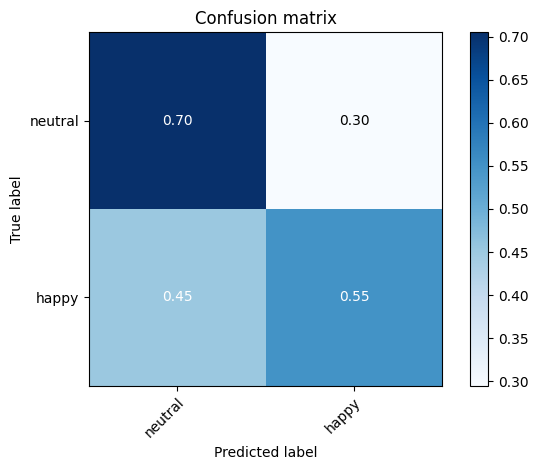

In [ ]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

### LDA on scaled data

Fitting LDA to scaled training set
done in 0.011s
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        61
           1       0.68      0.55      0.61        71

    accuracy                           0.62       132
   macro avg       0.63      0.63      0.62       132
weighted avg       0.63      0.62      0.62       132

Normalized confusion matrix
[[0.70491803 0.29508197]
 [0.45070423 0.54929577]]


<Figure size 640x480 with 0 Axes>

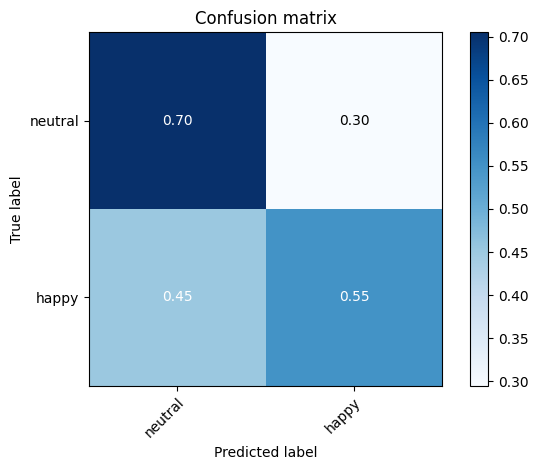

In [ ]:
# Fitting LDA to scaled data
print("Fitting LDA to scaled training set")
t0 = time()
lda_scale = LinearDiscriminantAnalysis()
lda_scale.fit(X_train_scale, y_train)
y_pred = lda_scale.predict(X_test_scale)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

### LDA on normalized data

Fitting LDA to normalized training set
done in 0.012s
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        61
           1       0.68      0.55      0.61        71

    accuracy                           0.62       132
   macro avg       0.63      0.63      0.62       132
weighted avg       0.63      0.62      0.62       132

Normalized confusion matrix
[[0.70491803 0.29508197]
 [0.45070423 0.54929577]]


<Figure size 640x480 with 0 Axes>

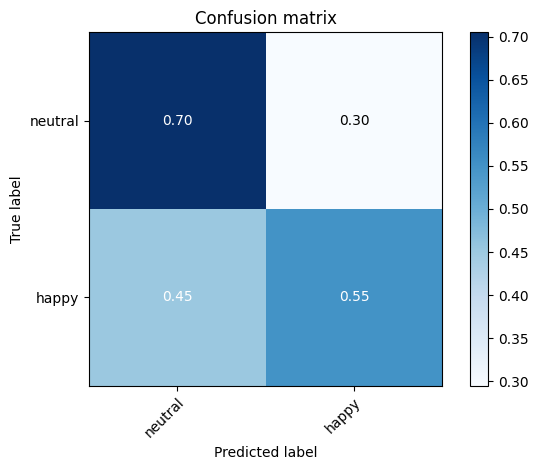

In [ ]:
# Fitting LDA to normalized data
print("Fitting LDA to normalized training set")
t0 = time()
lda_normalize = LinearDiscriminantAnalysis()
lda_normalize.fit(X_train_normalize, y_train)
y_pred = lda_normalize.predict(X_test_normalize)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

## Cross validation for model assessement

### CV on original data (dist_average)



---

We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today.

---






In [ ]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.107s
 Average and std CV score : 0.5225000000000001 +- 0.04636809247747852
Fitting QDA
done in 0.150s
 Average and std CV score : 0.58 +- 0.0465026880943457
Fitting Logistic Regression
done in 0.078s
 Average and std CV score : 0.54 +- 0.07044501401802686
Fitting Naive-Bayes
done in 0.031s
 Average and std CV score : 0.6174999999999999 +- 0.03674234614174766
Fitting K-nearest neighbour
done in 0.534s
 Average and std CV score : 0.6325 +- 0.025739075352467493


### CV and adding a preprocessing to the pipeline (on dist_average)

---
**Question**: compare the performances between original, scaled and normalized data

Be careful, if you want to standardize your data within a cross validation it means that you should fit 'StandardScaler()' only to the K-1 training folds without using the K-th test fold ! And then transform all folds.
How can we do that ?

Scikit-learn gives us a very nice tool: THE PIPELINE ! It makes it easier to chain standardization, normalizations, etc. with estimators during a cross validation. Please have a look here: https://scikit-learn.org/stable/common_pitfalls.html

How can we build a Pipeline? It's very simple. Just concatenate the trasformation and the the estimator you want to use:

model = make_pipeline(StandardScaler(), LinearRegression())

---


**Answer**

The results are very similar. However we noitce a slight improvement when using the standarization

In [ ]:
# Cross-validation for Model Assessment with Standaridzation
print("Cross-validation for Model Assessment with Standaridzation")
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline(StandardScaler(), LogisticRegression())
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))



# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline(StandardScaler(), GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh =  make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Cross-validation for Model Assessment with Standaridzation
Fitting LDA
done in 0.158s
 Average and std CV score : 0.5225000000000001 +- 0.04636809247747852
Fitting QDA
done in 0.180s
 Average and std CV score : 0.58 +- 0.0465026880943457
Fitting Logistic-regression
done in 0.373s
 Average and std CV score : 0.5375 +- 0.03791437722025776
Fitting Naive-Bayes
done in 0.062s
 Average and std CV score : 0.6174999999999999 +- 0.03674234614174766
Fitting K-nearest neighbour
done in 0.127s
 Average and std CV score : 0.595 +- 0.05454356057317858


### CV for hyperparameter selection using GridSearchCV

#### GridSearch on the whole data


---

In the previous example we have fixed the hyper-parameter K to 3. We could use CV to find the best value.

---



The best K is 7  with an average validation score equal to  0.65


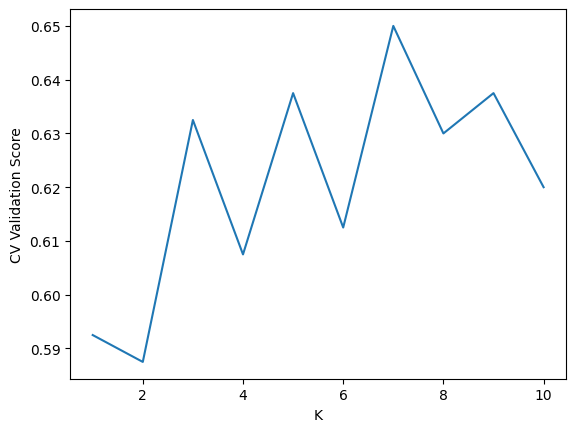

In [ ]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')
plt.show();

#### GridSearch on train_data and testing afterwards



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6229909154437456
The test score is 0.5984848484848485


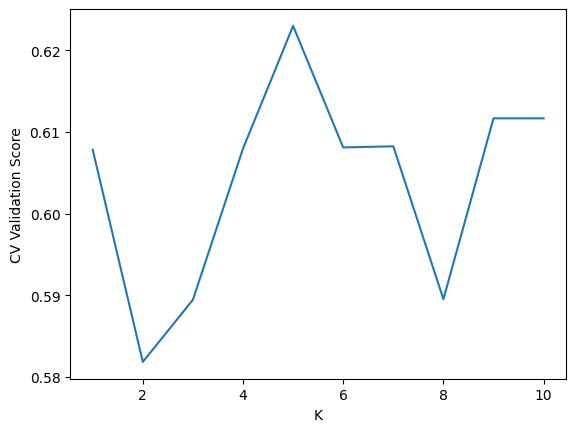

In [ ]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previous experiments. What about the best K and validation/test error ? Are the results the same ? Why in your opinion ?



---



**Answer**



The difference between the experiments is that in the first one, we are taking the whole dataset, and running Cross-validation over it Here we are assuming that the results are the generatlization ones. That is, we are dividing the dataset in K=5, and returning the statistic (validation score) of the best run of Cross-Validation. In the second one, we are doing that with just the training set, and then using the chosen best model over the test set. In fact, by injecting only the training set we are implicitly dividing our data into train-validation and assessing the best hyperparmeter (number of neighbours) each time. Then we are conducting our generalization test after choosing the best value of hyperparameter.

The obtained K is not the same in the two cases. This can be explained by the fact that we are hiding a part of the data and assessing the value of K only on a part of the whole set. This may lead to some values outperforming the K found in the first case. The results aswell are not the same and differs slightly with the validation score going from 65% to 62%.

This difference is given by the way our dataset was divided, usually having more data will mean better results, so that's why the cross validation score in the first one is higher.

# Preprocessing again : Extracting new features : distances between landmarks

## Feature extraction



---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [ ]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))
for sample_index in range(N):
  sample = XpGPA[sample_index].reshape((M,2))
  current_feature_index =0
  for i in range (M):
    for j in range (i+1,M):
      x_i,y_i = sample [i]
      x_j,y_j = sample [j]

      dist_combination[sample_index,current_feature_index] = np.sqrt((x_i-x_j)**2 +(y_i-y_j)**2)
      current_feature_index +=1
print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )


Number of subjects N is:  400  ; number of features is:  2278


## Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dist_combination, np.ravel(Yp), test_size=0.33, random_state=42)

## Scaling/Normalizing data

**Question**: Should we scale/normalize the new features ?

Yes, we need to normalize the new features (and not necessarly scale since we are dealing with features with same unit). In fact, some features are much larger than others especially in the case of two distant landmark that gives a high value compared to two close ones. But we are not telling our model that the distance value itself is irrelevant but the combinations between different features is more important.

In [ ]:
# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)
X_scale = scaler.transform(dist_combination)

# Normalize data (each feature will be scaled into the range 0,1)

normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)
X_normalize = normalizer.transform(dist_combination)


# Training and comparing models using the new features (distance between landmarks)

Use the classification algorithms seen before to test the discriminative power of the new features.

**Answer**

As we will see below, with these new features, we are able to raise the performance and our prediction in all the models. Especially, we get the results :      

For KNN algorithm, the best K is 9  with an average validation score equal to  0.940461215932914 with a test score is 0.946969696969697 which is pretty good

## Cross validation for model assessement

### CV and adding normalization to the pipeline (on dist_combination)

In [ ]:
# Cross-validation for Model Assessment with Normalization
print("Cross-validation for Model Assessment with Normalization")
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline(MinMaxScaler(), LogisticRegression())
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))



# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline(MinMaxScaler(), GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh =  make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Cross-validation for Model Assessment with Normalization
Fitting LDA
done in 2.304s
 Average and std CV score : 0.9099999999999999 +- 0.03984344362627307
Fitting QDA


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.734s
 Average and std CV score : 0.595 +- 0.07483314773547882
Fitting Logistic-regression
done in 1.633s
 Average and std CV score : 0.97 +- 0.01870828693386972
Fitting Naive-Bayes
done in 0.174s
 Average and std CV score : 0.95 +- 0.023717082451262844
Fitting K-nearest neighbour
done in 0.192s
 Average and std CV score : 0.9400000000000001 +- 0.03391164991562637


### CV for hyperparameter selection using GridSearchCV

#### GridSearch on the whole data

The best K is 3  with an average validation score equal to  0.9475


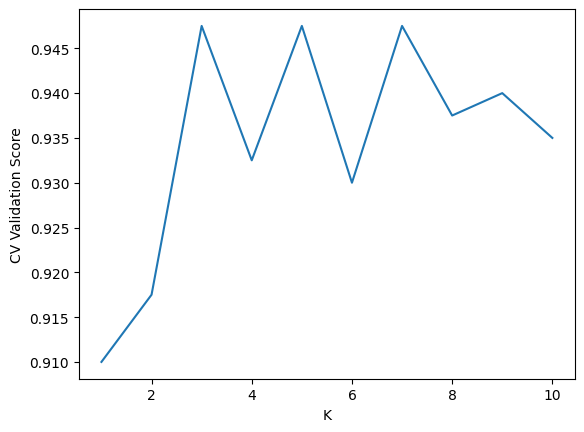

In [ ]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_combination, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')
plt.show();

#### GridSearch on train_data and testing afterwards

The best K is 9  with an average validation score equal to  0.940461215932914
The test score is 0.946969696969697


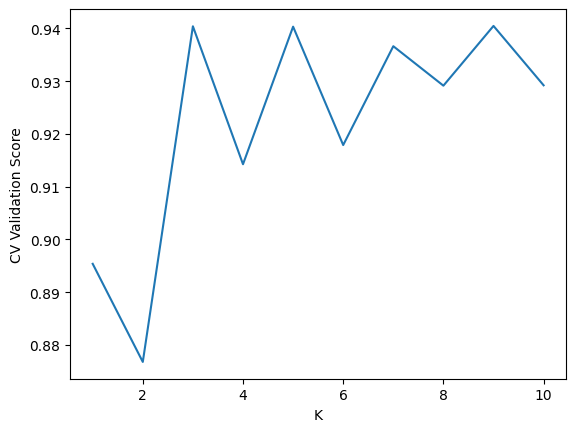

In [ ]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))

# Further enhancing the features : Reducing redundancy and then training

## Reducing colinearity/redundancy



---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy.

**Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the predictive power of the new features.




---



In order to reduce the colinearity/redyndancy issue we can proceed with PCA. In fact, PCA is very performant in reducing the number of variable that linearly depend on others and only keeps new orthognal basis (that is each feature is linearly independant of others).

As we will see, we will reduce considerably the dimensionality of the problem and consider only 42 features instead of 2278 while keeping 99% of the variablity of the data. In addition, this will enable us to keep the performance on the same level since here we obtain with the KNN algorithm 0.9475 accuracy with crossvalidation

In [ ]:
print("Before PCA: ")
print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )

pca = decomposition.PCA(n_components=0.99) # using number of components that explain 99% of variability as in last TP
dist_combination_pca = pca.fit_transform(X_scale) # Using the scaled data for PCA

print("\nAfter PCA: ")
print('Number of subjects N is: ', dist_combination_pca.shape[0], ' ; number of features explaining 99% of variance : ',  dist_combination_pca.shape[1] )

Before PCA: 
Number of subjects N is:  400  ; number of features is:  2278

After PCA: 
Number of subjects N is:  400  ; number of features explaining 99% of variance :  42


## Training and comparing models using the new features (distance between landmarks +PCA)

### Cross validation for model assessement

In [ ]:
# Cross-validation for Model Assessment
print("Cross-validation for Model Assessment ")
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline( LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline( QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic-regression")
t0 = time()
logit = make_pipeline( LogisticRegression())
logit_score = cross_val_score(logit,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))



# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = make_pipeline( GaussianNB())
GNB_score = cross_val_score(GNB,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh =  make_pipeline( KNeighborsClassifier(n_neighbors=3))
neigh_score = cross_val_score(neigh,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Cross-validation for Model Assessment with Normalization
Fitting LDA
done in 0.104s
 Average and std CV score : 0.9574999999999999 +- 0.016955824957813195
Fitting QDA
done in 0.126s
 Average and std CV score : 0.9275 +- 0.01837117307087385
Fitting Logistic-regression
done in 0.498s
 Average and std CV score : 0.9675 +- 0.01870828693386972
Fitting Naive-Bayes
done in 0.064s
 Average and std CV score : 0.9475 +- 0.022912878474779172
Fitting K-nearest neighbour
done in 0.172s
 Average and std CV score : 0.9349999999999999 +- 0.03391164991562637


### GridSearch on the whole data for hyperparameter selection

The best K is 5  with an average validation score equal to  0.9475


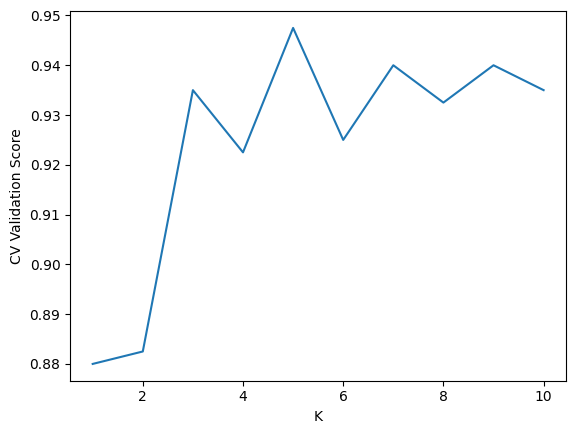

In [ ]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_combination_pca, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')
plt.show();

# Manually extracting features



---


A second solution, would be to manually select few landmarks



---



In [ ]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)

indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2)
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]

Yps=Yp

print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )

Number of subjects N is:  400  ; number of features is:  12


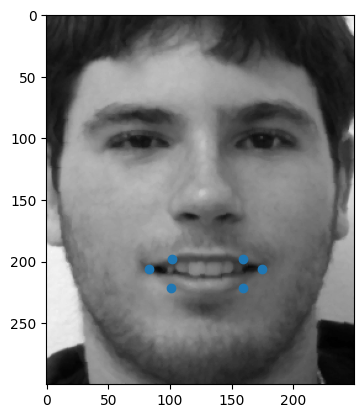

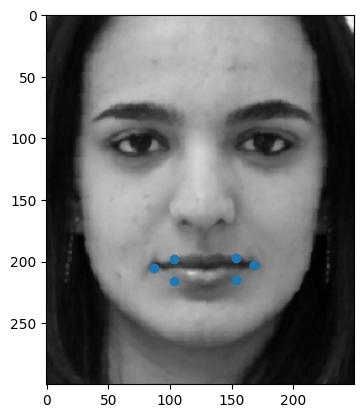

In [ ]:
# plot two test images
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

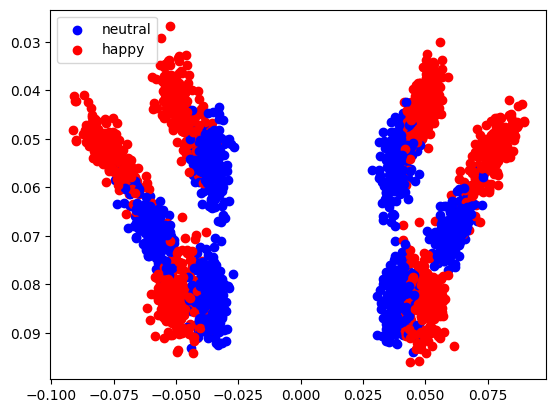

In [ ]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')

plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [ ]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.9543750000000001 +- 0.007288689868556599
 Average and std test score : 0.9475 +- 0.022912878474779172


---

Let's plot some images where the best model was wrong.

---

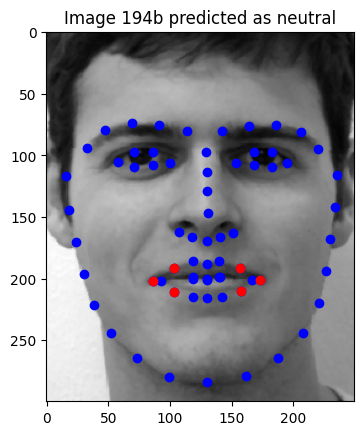

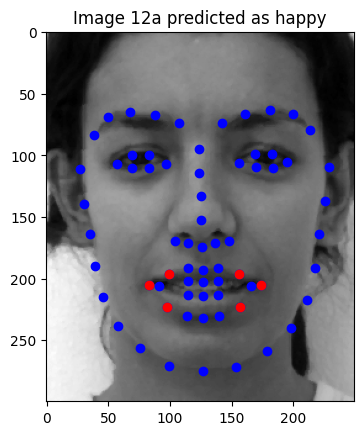

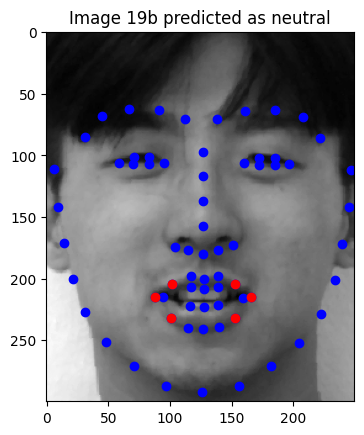

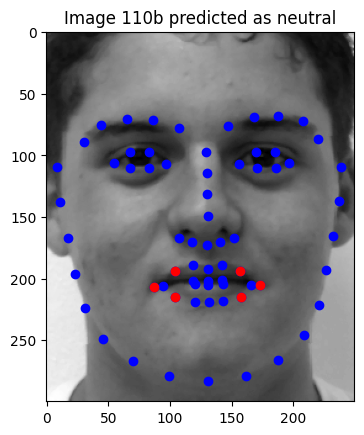

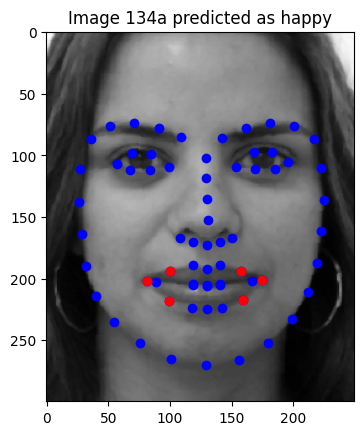

In [ ]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()


**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks


The algorithm mistake these images because by looking only at the mouth we are still not sure wether a person that we have never seen his face is smile or the face structure is like that in normal state. If we considere the image 134a we can see that if crop the whole image and leave the mouth we are almost sure that the person is smiling (even I thought that she was smiling and had to remove the markers to verfiy that she is not). Thus, additional information needs to be present such as the eyebrows for example.

# Trying different manually selected landmarks

Try at least another combination of landmarks :

By adding 6 landmarks (the eyebrows) we are able to improve slightly the performance of our model whose accuracy goes from 0.947 to 0.954 on test data. This prves that although in most cases we are able to correctly identify the emotion using only the mouth landmarks, there are other cases in which this information is not enough to make the prediction. In such cases, other indicators has to be added

Number of subjects N is:  400  ; number of features is:  28


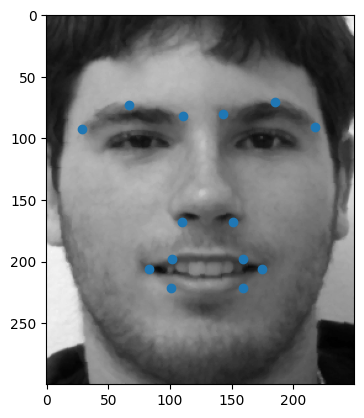

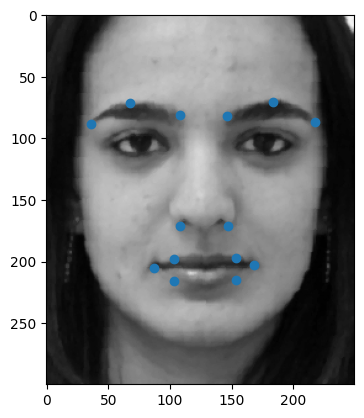

Fitting LDA
 Average and std train score : 0.9637500000000001 +- 0.0015309310892394536
 Average and std test score : 0.9549999999999998 +- 0.018708286933869726


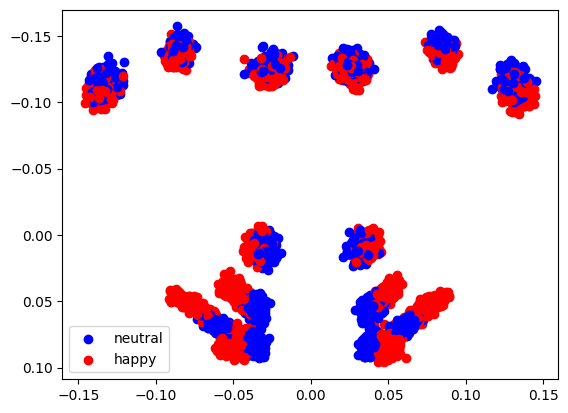

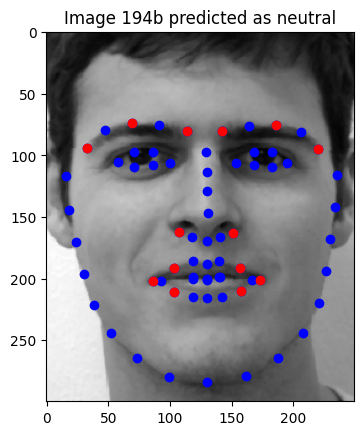

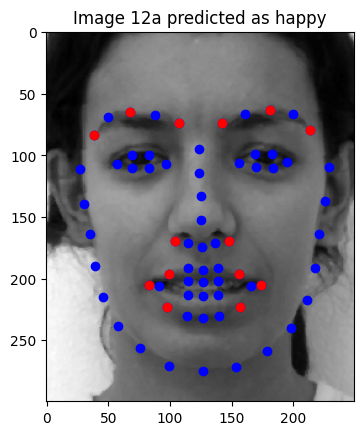

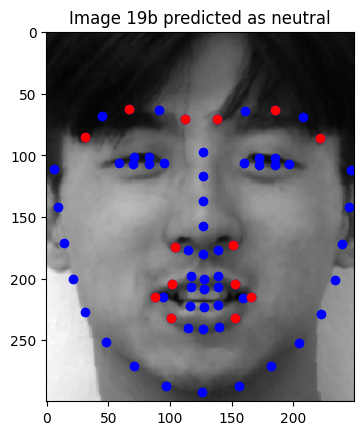

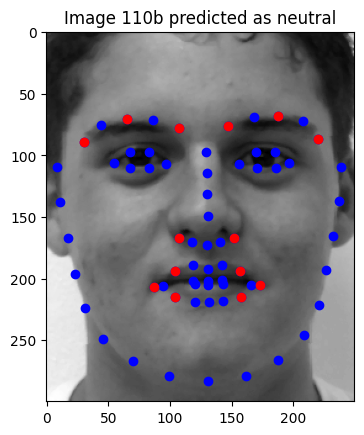

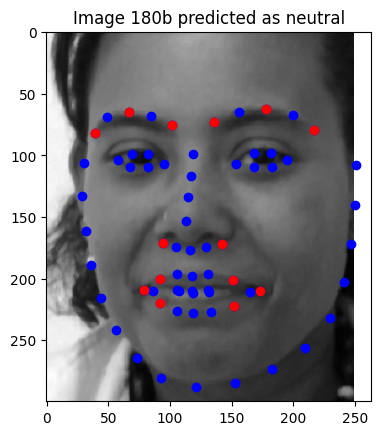

In [ ]:
# Select a different composition of landmarks (mouth + eyes
select_land=[49,50,60,55,54,56,18,20,22, 23,25,27,32,36]  #adding eyebrows landmarks
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)

indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2)
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]

Yps=Yp

print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )

# plot two test images
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')

plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))
if len(error)>5:
    kk=5
else:
    kk=len(error)
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()

# Nested Cross-validation for Generalization error and the best K value




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [ ]:
# Fitting K-nearest neighbour with Nested Cross-Validation

print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 6.097s
Average and std Nested Cv train score : 0.9662499999999999 +- 0.017940875118009156
Average and std Nested Cv test score : 0.9475 +- 0.009354143466934856


---

**Question**: Are Training and Test scores similar ? What does it mean ?

---

Yes. The train score and the test score are similar. This indicates that our model is a good fit for this problem. In fact, using it, we are able to explain the training set and generalize to the unviewed data set with test score higher than 0.94 in both cases. This means that we are not overfitting (because the training score is high) and we are not underfitting (because the training score is high)


**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power